In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.core import Dropout
from  sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
Classifier=Sequential()
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
#models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display
pd.options.display.max_columns = None
display()
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
import teradata
import pandas as pd
host,user,pwd ='10.132.4.11','Dummy', "Dummy@123"
udaExec =teradata.UdaExec (appName="HelloWorld", version="1.0",logConsole=False)
with udaExec.connect(method="ODBC", system=host,username=user,password=pwd) as session:
    query = '''SELECT * from  dw_ckm.vim_cc_rev_base7'''
    Base= pd.read_sql(query,session)  
#print(df.columns.tolist()) #columns 
print(Base.shape) 

In [3]:
#Base.to_excel('C:\\Users\\tvimal\\Desktop\\GITHUB_REVOLVER_DATA.xlsx')
Base=pd.read_excel('C:\\Users\\tvimal\\Desktop\\GITHUB\\GITHUB_REVOLVER_DATA.xlsx')

In [ ]:
Base.columns

In [5]:
Training_data=Base.drop(['FEATURE_29','FEATURE_36'],axis=1)#Based on business Understanding

In [6]:
Training_data=Training_data.set_index('PARTY_ID')
Training_data[['IND_1', 'IND_2','IND_3','INDI_4']]=Training_data[['IND_1', 'IND_2','IND_3','INDI_4']].astype(object)

# Exploratory Data Analysis

Missing Value Percentage

Your dataframe has 97 columns.
There are 88 columns that have missing values.


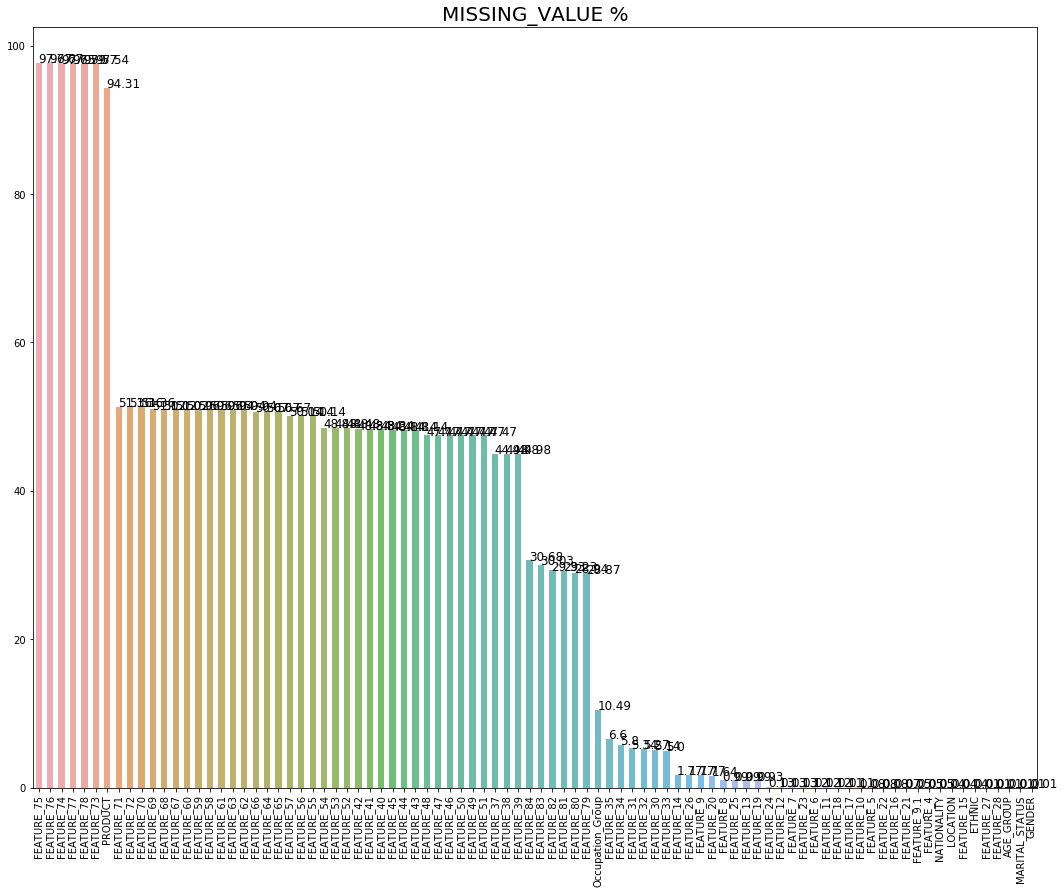

In [9]:
def missing_values_table(Training_data):
    mis_val = Training_data.isnull().sum()
    mis_val_percent = 100 * Training_data.isnull().sum() / len(Training_data)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(2)
    print ("Your dataframe has " + str(Training_data.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")
    plt.figure(figsize=(18,14))
    ax=sns.barplot(mis_val_table_ren_columns.index, mis_val_table_ren_columns['% of Total Values'].values, alpha=0.8)
    for i in ax.patches:
            # get_x pulls left or right; get_height pushes up or down
            ax.set_title('MISSING_VALUE %',fontdict={'fontsize':20}),#'fontweight' :20,'verticalalignment': 'baseline', 'horizontalalignment': loc}
            current_width = i.get_width()
            diff = current_width -.55
            i.set_width(.55)
            i.set_x(i.get_x() + diff * .5)
            
            ax.text(i.get_x()+0.2,i.get_height(),\
                    str(round((i.get_height()),2)), fontsize=12,color='black')##total)*100
    plt.xticks(rotation='vertical')
    plt.show()
missing_values_table(Training_data)

Category Counts for Discrete Features

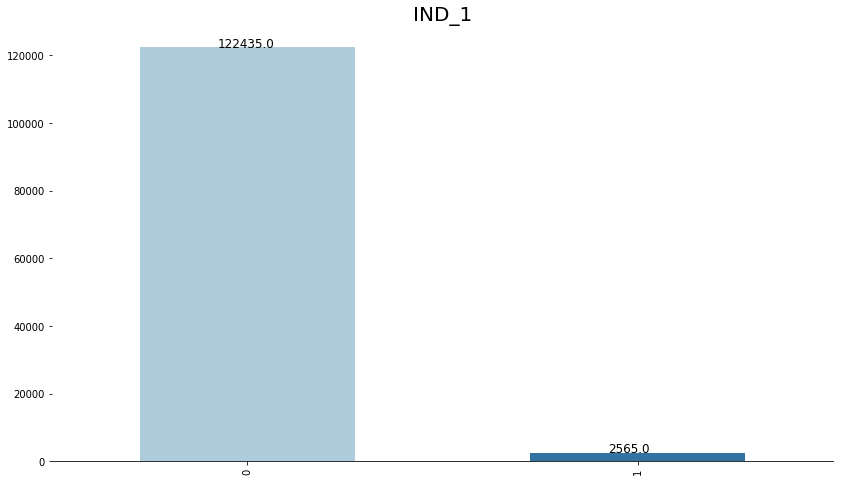

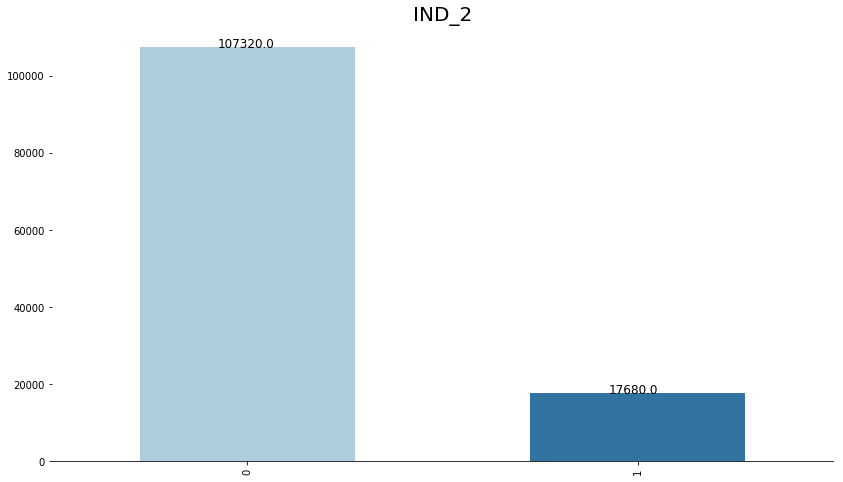

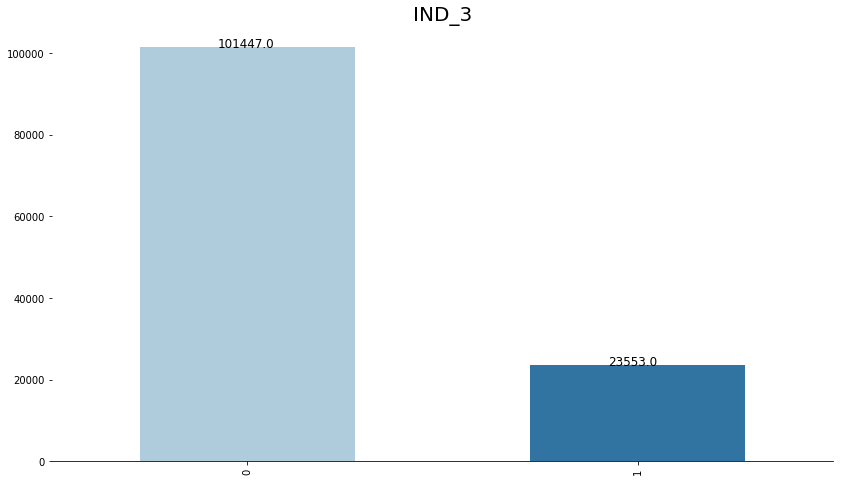

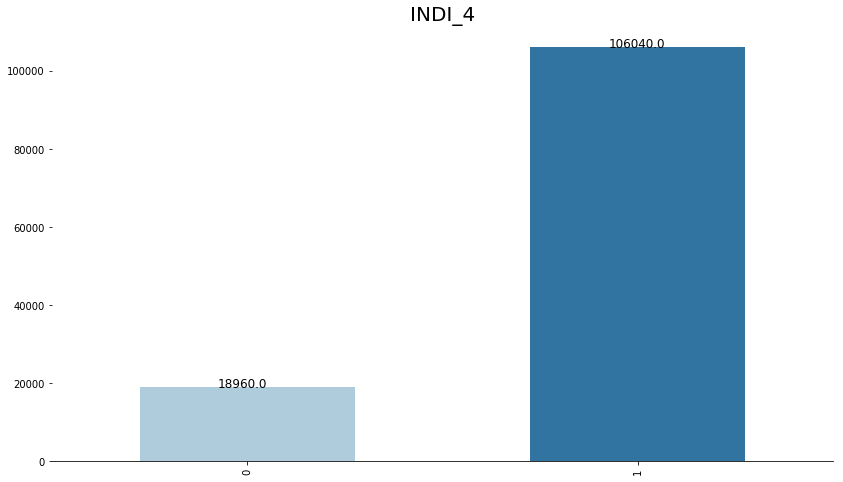

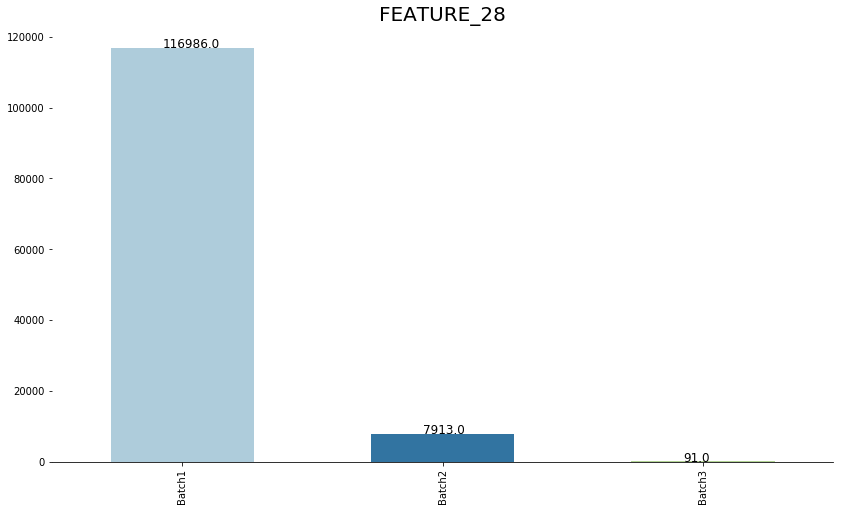

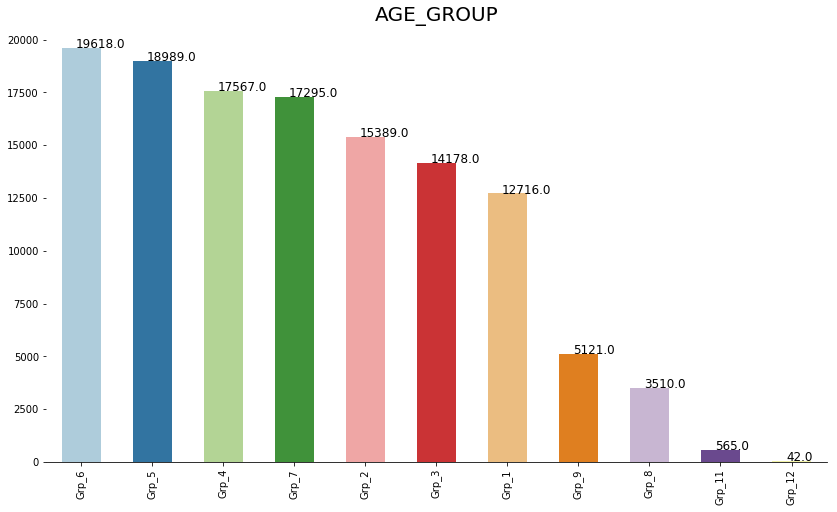

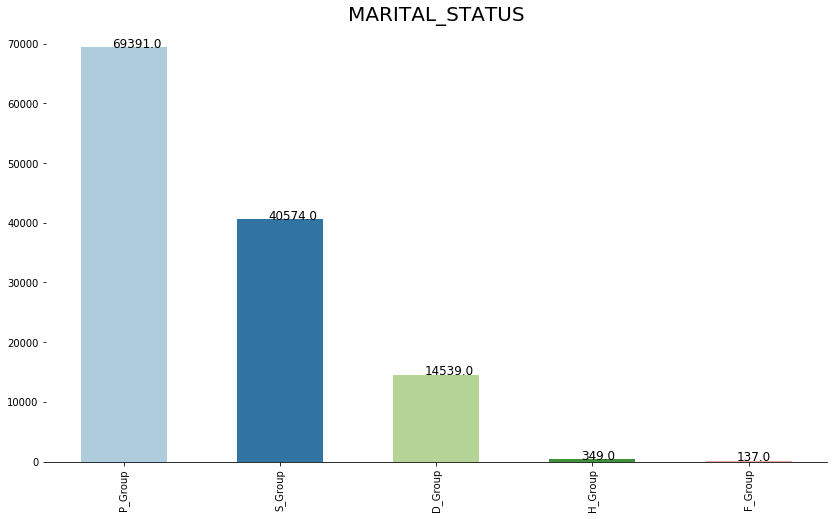

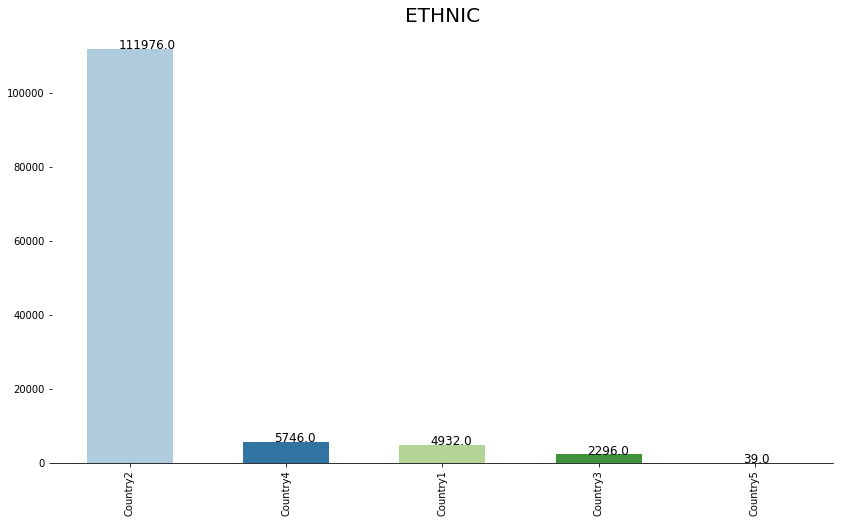

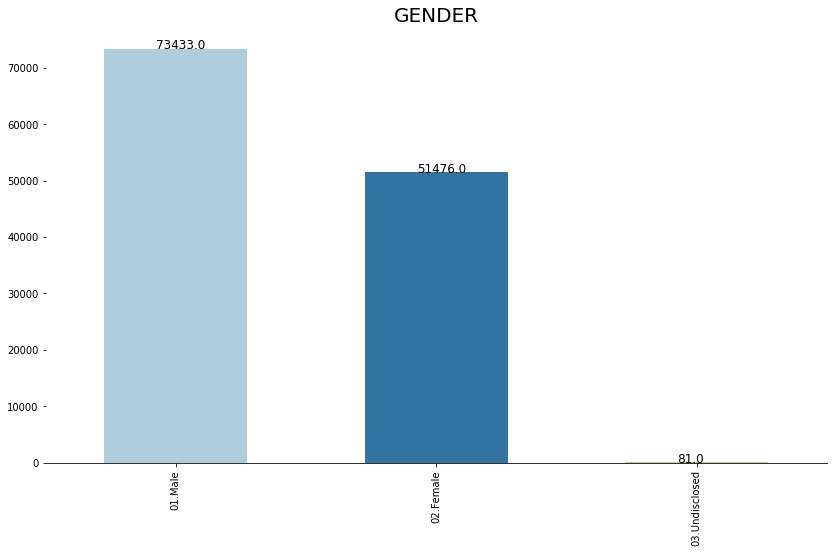

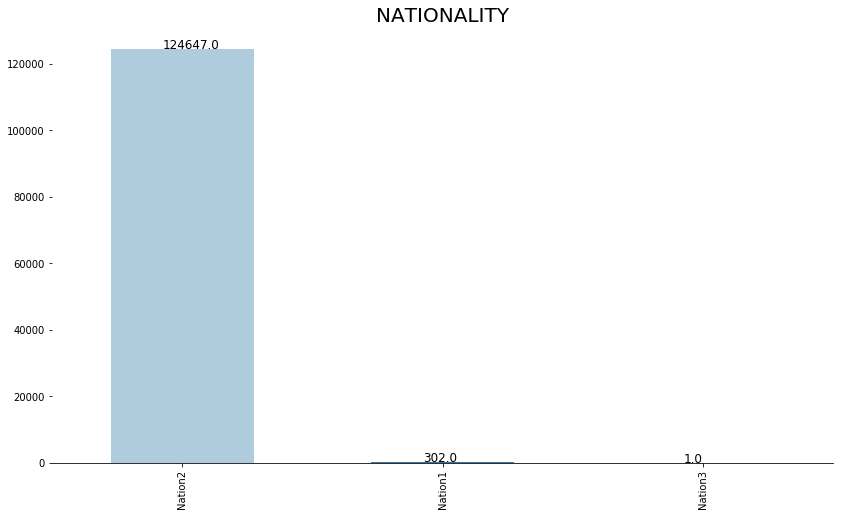

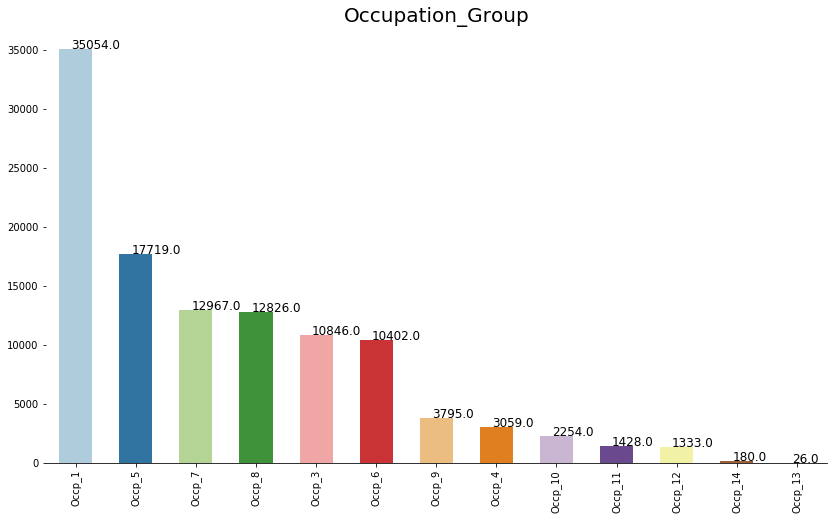

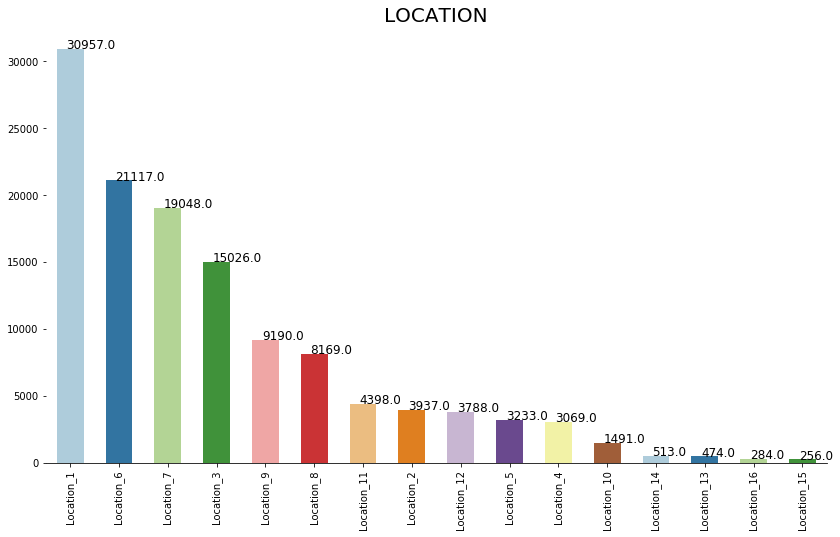

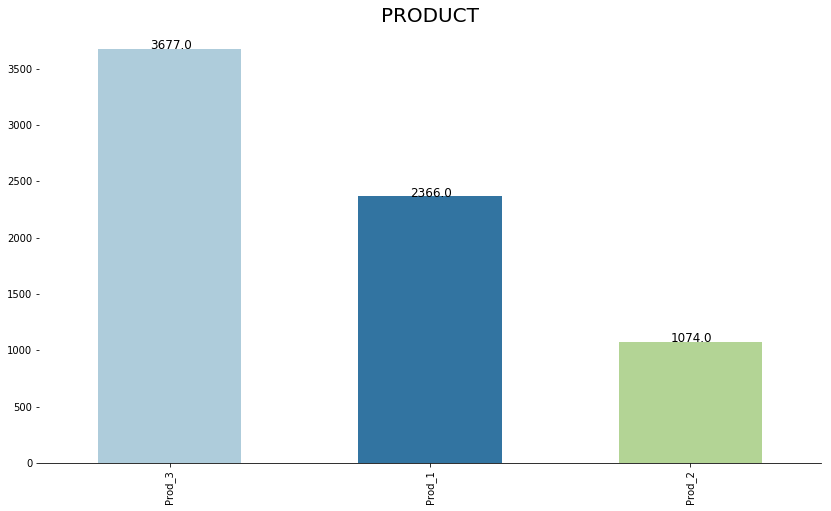

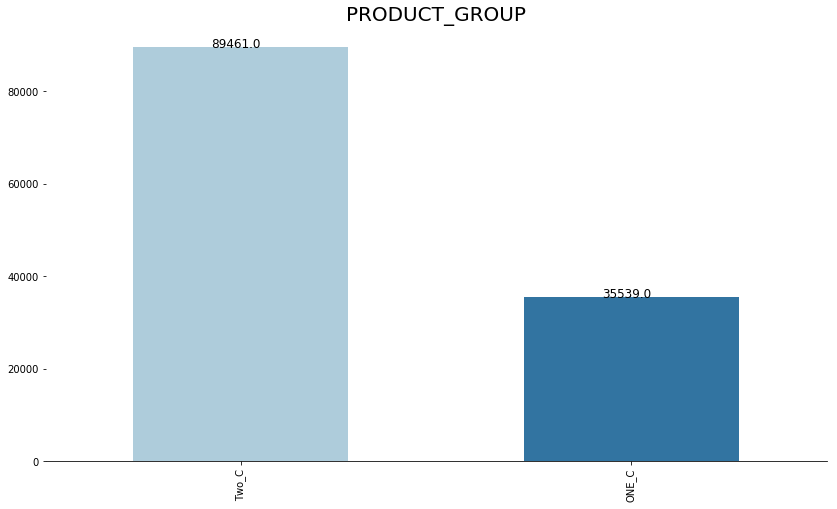

In [10]:
cat=[];numl=[]    
for feature in Training_data.columns.tolist():
    if Training_data[feature].dtype=='object':
        cat.append(feature)
    else:
        numl.append(feature)
for column in cat:
    def plot_categorical_count(Training_data, column, title='', limit=10,xtick_rotation='vertical'):
        column_count = Training_data[column].value_counts()#[:limit]
        fig = plt.figure(figsize=(14, 8))
        ax=sns.barplot(x=column_count.index, y=column_count.values, palette='Paired')
        sns.despine(left=True)
        plt.title(title, fontsize=16)
        plt.xticks(rotation=xtick_rotation)
        for i in ax.patches:
            # get_x pulls left or right; get_height pushes up or down
            ax.set_title(column,fontdict={'fontsize':20}),#'fontweight' :20,'verticalalignment': 'baseline', 'horizontalalignment': loc}
            current_width = i.get_width()
            diff = current_width -.55
            i.set_width(.55)
            i.set_x(i.get_x() + diff * .5)            
            ax.text(i.get_x()+0.2,i.get_height(),\
                    str(round((i.get_height()),2)), fontsize=12,color='black')##total)*100
    plt.show(plot_categorical_count(Training_data, column, title=column, limit=10))

Difference Between Two Classes for Categorical Data

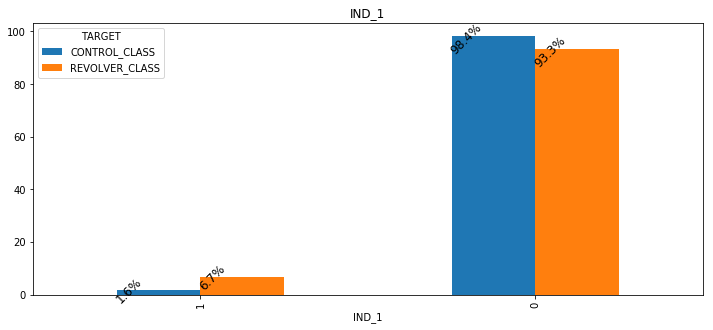

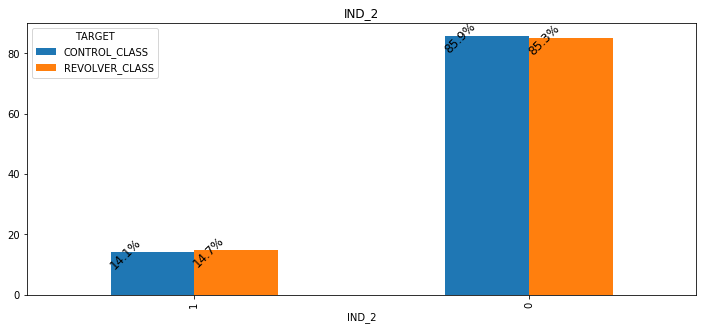

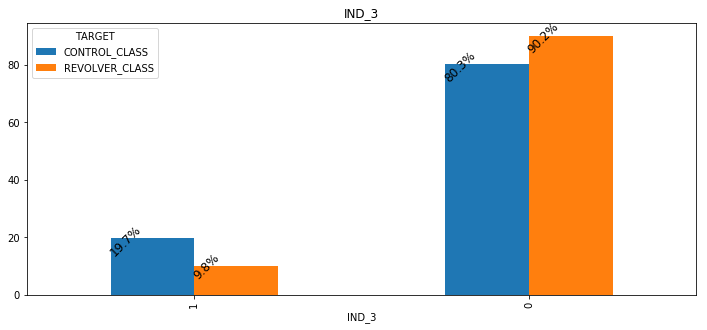

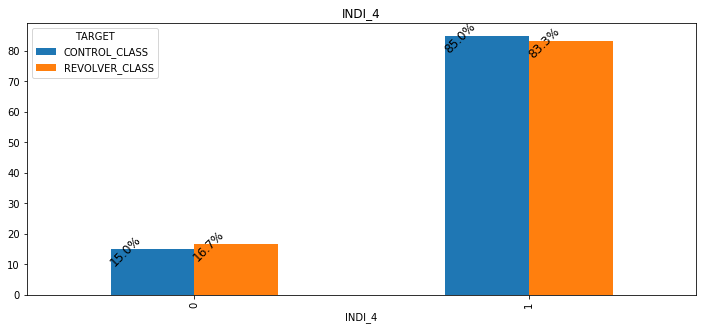

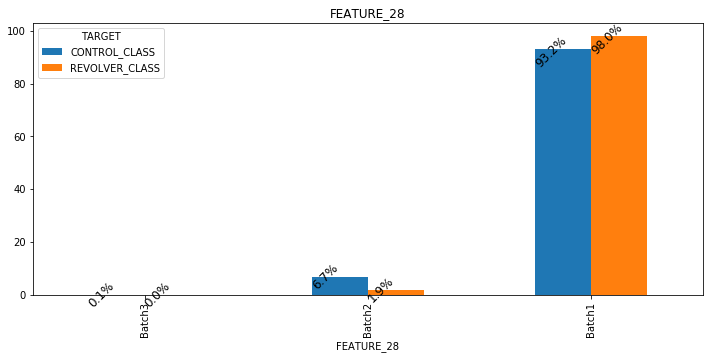

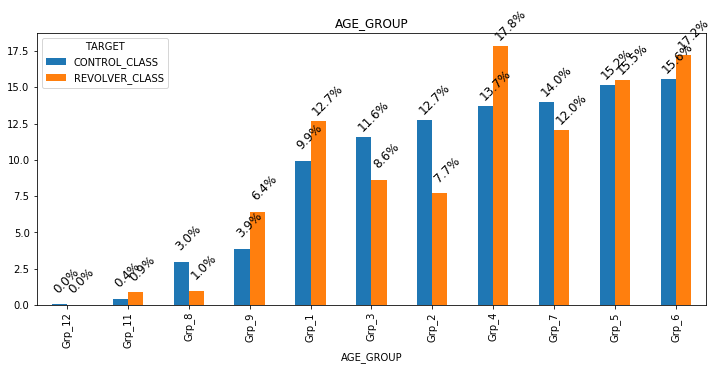

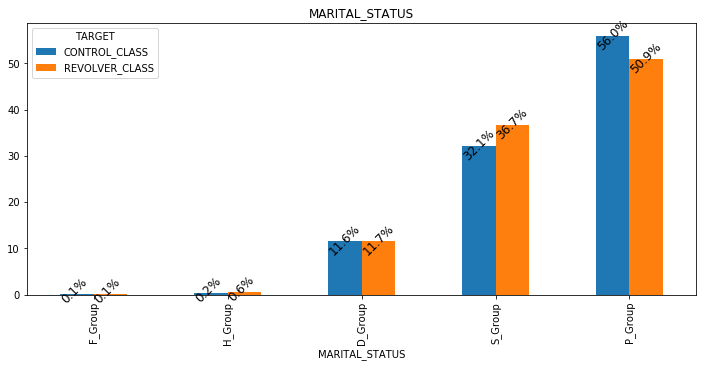

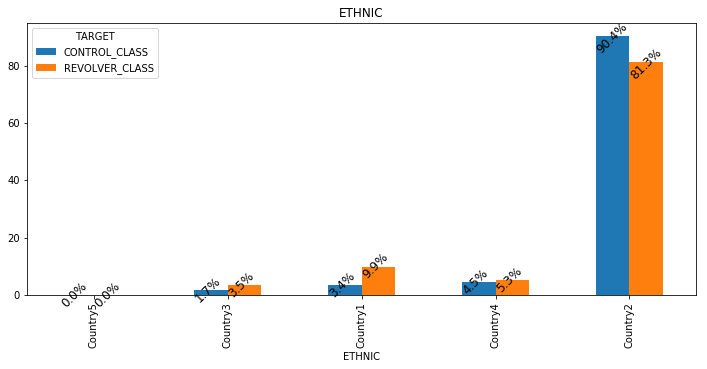

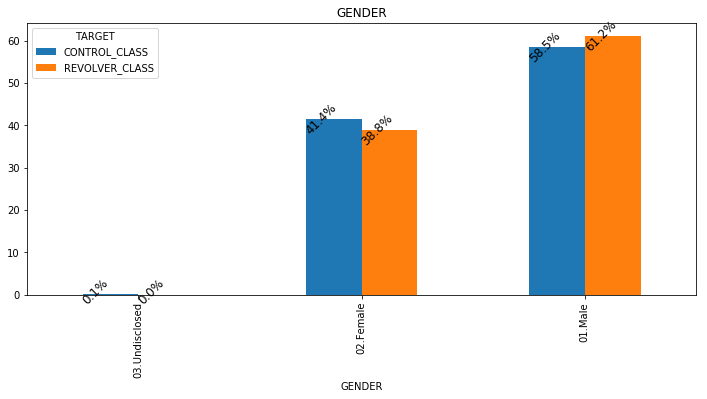

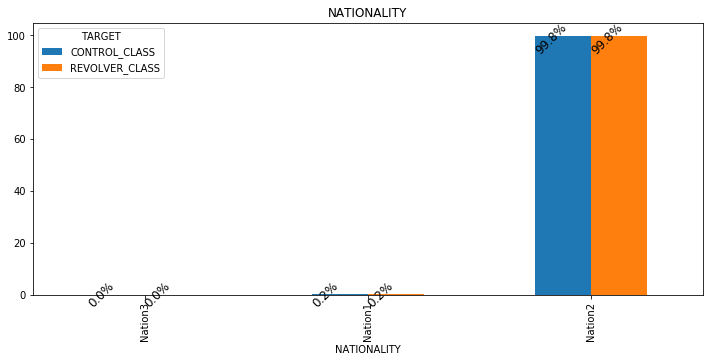

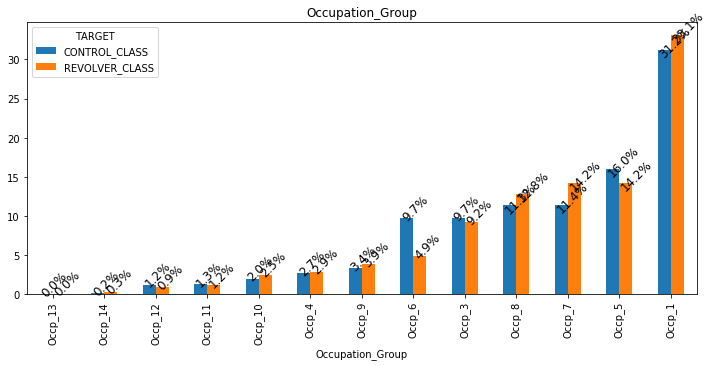

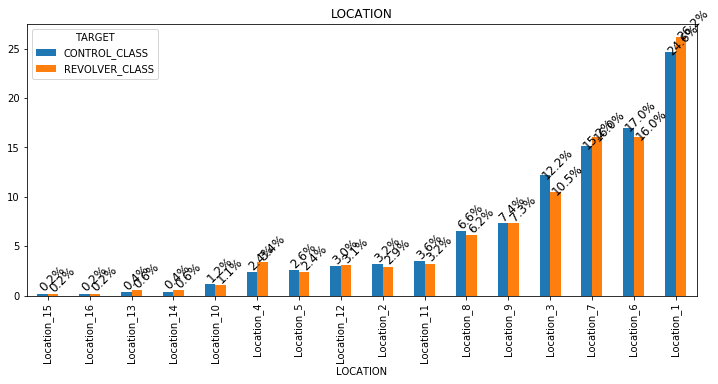

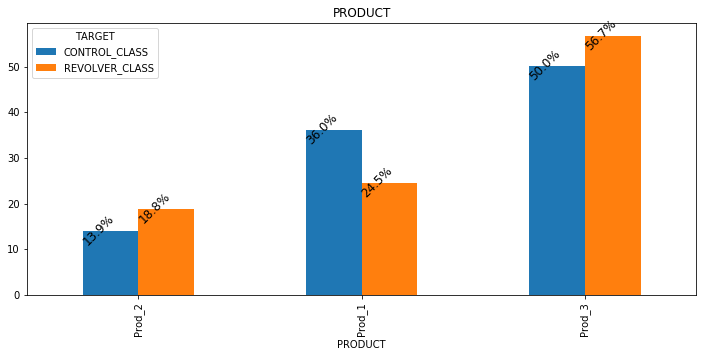

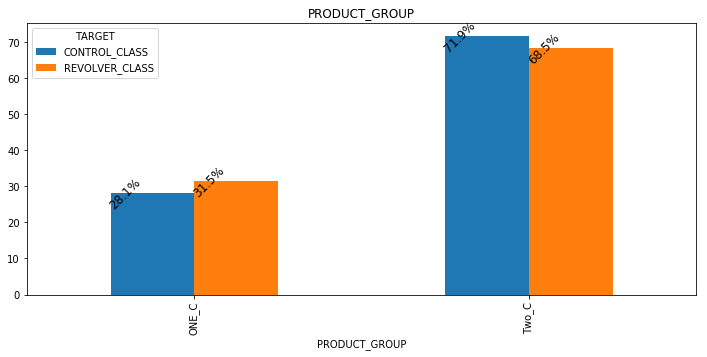

In [11]:
for name  in cat: 
    fnl=pd.crosstab(index=Training_data[name], columns=Training_data['TARGET'])
    fnl['CONTROL_CLASS']=np.round(fnl[0]/fnl[0].sum(),4)*100
    fnl['REVOLVER_CLASS']=np.round(fnl[1]/fnl[1].sum(),4)*100
    okk=fnl[['CONTROL_CLASS','REVOLVER_CLASS']].sort_values(by='CONTROL_CLASS')#,ascending=False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    ax=okk[['CONTROL_CLASS','REVOLVER_CLASS']].plot(kind='bar', figsize=(12,5),title=name,grid=False)#subplots=True
    #plt.annotate( label,  (okk.index,okk['one_class'].values),   xytext=(0, space), textcoords="offset points", ha='center', va=va)
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()-.01,i.get_height()+ 2,\
                str(round((i.get_height()/100)*100, 1))+'%', fontsize=12,color='black',rotation=45)
        #filename = 'C:\\Users\\tvimal\\Desktop\\' + str(name) +'.png'
        #plt.savefig(filename, dpi=300, format='png', bbox_inches='tight')

Difference Between Two Classes for Numeric Data

In [ ]:
cat=[];numl=[]    
for feature in Training_data.columns.tolist():
    if Training_data[feature].dtype=='object':
        cat.append(feature)
    else:
        numl.append(feature)
numlist=numl
numlist.remove('TARGET')
for var in numlist:
    def means(var):
        dff=Training_data[[var,'TARGET']]
        g=dff.groupby('TARGET').agg('mean')
        dfs = pd.DataFrame(g, index=[0,1]).rename(columns={0:'MEAN_CONTROL_CLASS',1:'MEAN_ONE_CLASS'})
        ax=sns.barplot(x=dfs.index, y=np.array(dfs.values).ravel())
        for i in ax.patches:
            # get_x pulls left or right; get_height pushes up or down
            ax.set_title(var,fontdict={'fontsize':20}),#'fontweight' :20,'verticalalignment': 'baseline', 'horizontalalignment': loc}
            current_width = i.get_width()
            diff = current_width -.55
            i.set_width(.55)
            i.set_x(i.get_x() + diff * .5)
            
            ax.text(i.get_x()+0.2,i.get_height(),\
                    str(round((i.get_height()),2)), fontsize=12,color='black')##total)*100
            #filename = 'C:\\Users\\tvimal\\Desktop\\' + str(var) +'.png'
            #plt.savefig(filename, dpi=300, format='png', bbox_inches='tight')
    plt.show(means(var))

Removing Anamolies & Imputation

In [13]:
imp_data=Training_data.drop(['TARGET'],axis=1)
#imputation for outliers removal
cat=[];numl=[]    
for feature in imp_data.columns.tolist():
    if imp_data[feature].dtype=='object':
        cat.append(feature)
    else:
        numl.append(feature)
imp_data[numl] = Imputer(strategy='mean').fit_transform(imp_data[numl])
imp_data = imp_data.fillna(imp_data.mode().iloc[0])
#outlier removal
from scipy import stats
behavior=imp_data[numl][(np.abs(stats.zscore(imp_data[numl]))<3).all(axis=1)]
behavior.shape
#getting raw data after outliers
After_outlr=Training_data[Training_data.index.isin(behavior.index)]
After_outlr.shape
#imputation after outlier removal
After_outlr[numl] = Imputer(strategy='mean').fit_transform(After_outlr[numl])
After_outlr = After_outlr.fillna(After_outlr.mode().iloc[0])
#t_data=anal.drop(['CUSTOMER_NBR', 'CC_TAG','REV_month','portfolio_open_dt','SCV_Party_ID','COC_BT_amt', 'Gross_Annual_Income'],axis=1)
#t_data=anal.set_index('new_scv_party_id')
print('TOTAL COUNTS OF REV AND CONTROL CLASS',After_outlr['TARGET'].value_counts())
FE_data=After_outlr #for feature Engineering

C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


TOTAL COUNTS OF REV AND CONTROL CLASS 0    95364
1     7888
Name: TARGET, dtype: int64


# FEATURE ENGINEERING

In [14]:
#utilisation    
#df['FE18'] = FE_data.apply(lambda x: x['FEATURE_4'] + x['FEATURE_5'], axis=1)
#df['FE18']=FE_data.iloc[:,[5,6]].sum(axis=1)
FE_data['FE18']= FE_data['FEATURE_4']+ FE_data[ 'FEATURE_5'];FE_data['FE19'] = FE_data[ 'FEATURE_8']+FE_data ['FEATURE_9']
FE_data['FE_B8']=FE_data['FE18']- FE_data['FE19'] 
#pymt 
FE_data['FE16']=FE_data[ 'FEATURE_9.1'] +FE_data['FEATURE_10'];FE_data['FE17'] =FE_data[ 'FEATURE_13'] +FE_data['FEATURE_14']
FE_data['FE_B7']=FE_data['FE16'] - FE_data['FE17']
#payratio
FE_data['FE14'] = FE_data['FEATURE_15'] + FE_data['FEATURE_16'];FE_data['FE15'] =FE_data['FEATURE_19'] + FE_data['FEATURE_20']
FE_data['FE_B6'] =FE_data ['FE14']-FE_data ['FE15']
#ENR
FE_data['FE12'] = FE_data ['FEATURE_21']+FE_data['FEATURE_22'] ;FE_data['FE13'] =FE_data['FEATURE_25']+FE_data['FEATURE_26']
FE_data['FE_B5'] = FE_data ['FE12']-FE_data ['FE13'] 
#RETAIL_TXN
FE_data['FE10'] = FE_data['FEATURE_30'] +FE_data['FEATURE_31'];FE_data['FE11'] =  FE_data ['FEATURE_34']+ FE_data['FEATURE_35']
FE_data['FE_B4']= FE_data['FE10']-FE_data['FE11']
#casa details             
FE_data['FE6'] =FE_data['FEATURE_38']+ FE_data['FEATURE_41'];FE_data['FE7']=FE_data['FEATURE_50']+ FE_data['FEATURE_53']
FE_data['FE_B2']=FE_data['FE6']-FE_data['FE7'] 
FE_data['FE8']=FE_data['FEATURE_56']+FE_data['FEATURE_59'];FE_data['FE9']=FE_data['FEATURE_68']+FE_data['FEATURE_71']
FE_data['FE_B3']=FE_data['FE8']-FE_data['FE9']
########## current balance 
FE_data['FE1']= FE_data['FEATURE_79']+FE_data['FEATURE_80'] +FE_data['FEATURE_81'];FE_data['FE2'] =FE_data['FEATURE_82']+FE_data['FEATURE_83'] +FE_data['FEATURE_84']
FE_data['FE4']=FE_data['FE1']/3
FE_data['FE5']=FE_data['FE2']/3
FE_data['FE_B1']= FE_data['FE4']-FE_data['FE5']
Train_data=FE_data.drop(['FEATURE_4','FEATURE_5','FEATURE_6','FEATURE_7','FEATURE_8','FEATURE_9','FEATURE_10','FEATURE_11','FEATURE_12','FEATURE_13','FEATURE_14','FEATURE_15','FEATURE_16','FEATURE_17','FEATURE_18','FEATURE_19','FEATURE_20','FEATURE_21','FEATURE_22','FEATURE_23','FEATURE_24','FEATURE_25','FEATURE_26','FEATURE_30','FEATURE_31','FEATURE_32','FEATURE_33','FEATURE_34','FEATURE_35',  'FEATURE_38','FEATURE_41','FEATURE_44','FEATURE_47','FEATURE_50','FEATURE_53',
                        'FEATURE_56','FEATURE_59','FEATURE_62','FEATURE_65','FEATURE_68','FEATURE_71', 'FEATURE_79','FEATURE_80','FEATURE_81','FEATURE_82','FEATURE_83','FEATURE_84','FE1','FE2'],axis=1)
Train_data=Train_data.drop(['FEATURE_37', 'FEATURE_39', 'FEATURE_40', 'FEATURE_42','FEATURE_43', 'FEATURE_45', 'FEATURE_46', 'FEATURE_48', 'FEATURE_49', 'FEATURE_51', 'FEATURE_52', 'FEATURE_54','FEATURE_55', 'FEATURE_57', 'FEATURE_58', 'FEATURE_60', 'FEATURE_61','FEATURE_63', 'FEATURE_64', 'FEATURE_66', 'FEATURE_67',     'FEATURE_69', 'FEATURE_70', 'FEATURE_72', 'FEATURE_73', 'FEATURE_74', 'FEATURE_75', 'FEATURE_76', 'FEATURE_77','FEATURE_78'],axis=1)
Train_data.shape

(103252, 44)

Null Hypothesis -- Significance Test

In [15]:
Sigf_test=Train_data.drop('TARGET',axis=1)
Sigf_test.columns
cat=[]
numl=[]
    
for feature in Sigf_test.columns.tolist():
    if Sigf_test[feature].dtype=='object':
        cat.append(feature)
    else:
        numl.append(feature)
#####################################    chi square     ############################
chistat=[]
p_val=[]
for i in cat:
    chi_table = pd.crosstab(index=Train_data[i], columns=Train_data['TARGET'])
    from scipy.stats import chi2_contingency
    stat, p, dof, expected = chi2_contingency(chi_table)
    #print( '%s ,chi_stat=%s ,p_value=%s' % (i,stat,p))
    chistat.append(stat)
    p_val.append(p)
    
chi=np.array(chistat)
p=np.array(p_val)
stat=np.column_stack((chi,p))
chi_stat=pd.DataFrame(stat).rename(columns={0:'CHI_STATS',1:"P_VALUE"})
chi_stat['INPUT_FEATURES']=list(cat)
chi_stat= chi_stat.set_index('INPUT_FEATURES')  # whole dataframe with non significant features
CONTRIBUT=chi_stat[chi_stat['P_VALUE']<0.01]  # set the threshold for  chi stat
con_feature=list(CONTRIBUT.index)
print ("TOTAL NUM OF CATEGORICAL INPUT_FEATURES=",len(cat))
print ("SIGNIFICANT CATEGORICAL_FEATURES=",len(CONTRIBUT))
print(CONTRIBUT)
con_feature  #list of contributed  features 
chi_stat
con_feature

######################################## F ANOVA   ####################################################
NUM_LIST=[]
for num in numl:  
    from scipy.stats import ttest_ind
    from scipy import stats
    f_anova=Train_data[['TARGET',num]]#.groupby('TARGET').mean()
    f_anova.groupby('TARGET').mean()
    f_anova=f_anova.replace(np.nan,0);  f_anova=f_anova.replace(np.inf,0); f_anova=f_anova.replace(-np.inf,0)
    cat1 = f_anova[f_anova['TARGET']==0];  cat2 =f_anova[f_anova['TARGET']==1]
    stat=stats.f_oneway(cat1[num], cat2[num])
   # print(num,'      '  ,stats.f_oneway(cat1[num], cat2[num]))
    #print(num,'  ',stat)
    NUM_LIST.append(stat)
value=[]
for i in range(len(NUM_LIST)):
    value.append(list(NUM_LIST[i]))
f_stat=pd.DataFrame(value).rename(columns={0:'F_STATTISTIC',1:"P_VALUE"})
f_stat['INPUT_FEATURES']=list(numl)
f_stat= f_stat.set_index('INPUT_FEATURES')
CONTRIBUTE=f_stat[f_stat['P_VALUE']<0.01]     # set the  significant threshold for f stat
con_features=list(CONTRIBUTE.index)
print ("TOTAL NUM OF CONTINUOUS NUMBER_FEATURES=",len(numl))
print ("SIGNIFICANT CONTINUOUS NUMBER FEATURES=",len(CONTRIBUTE))
#con_features  #list of contributed  features 
print(CONTRIBUTE)

TOTAL NUM OF CATEGORICAL INPUT_FEATURES= 10
SIGNIFICANT CATEGORICAL_FEATURES= 9
                    CHI_STATS        P_VALUE
INPUT_FEATURES                              
FEATURE_28         187.651943   1.786070e-41
AGE_GROUP          572.731274  1.220517e-116
MARITAL_STATUS      99.256091   1.416462e-20
ETHNIC            1031.108193  6.468695e-222
GENDER              20.636057   3.303217e-05
Occupation_Group   281.148906   4.219430e-53
LOCATION            90.268876   8.836540e-13
PRODUCT            625.880202  1.235495e-136
PRODUCT_GROUP       79.418884   5.024358e-19
TOTAL NUM OF CONTINUOUS NUMBER_FEATURES= 33
SIGNIFICANT CONTINUOUS NUMBER FEATURES= 32
                F_STATTISTIC        P_VALUE
INPUT_FEATURES                             
FEATURE_1         176.186037   3.557835e-40
IND_1             891.695502  4.269028e-195
IND_2               7.120464   7.622088e-03
IND_3             439.035960   2.800899e-97
INDI_4             34.137521   5.150498e-09
FEATURE_2          82.128798  

Correlation Matrix

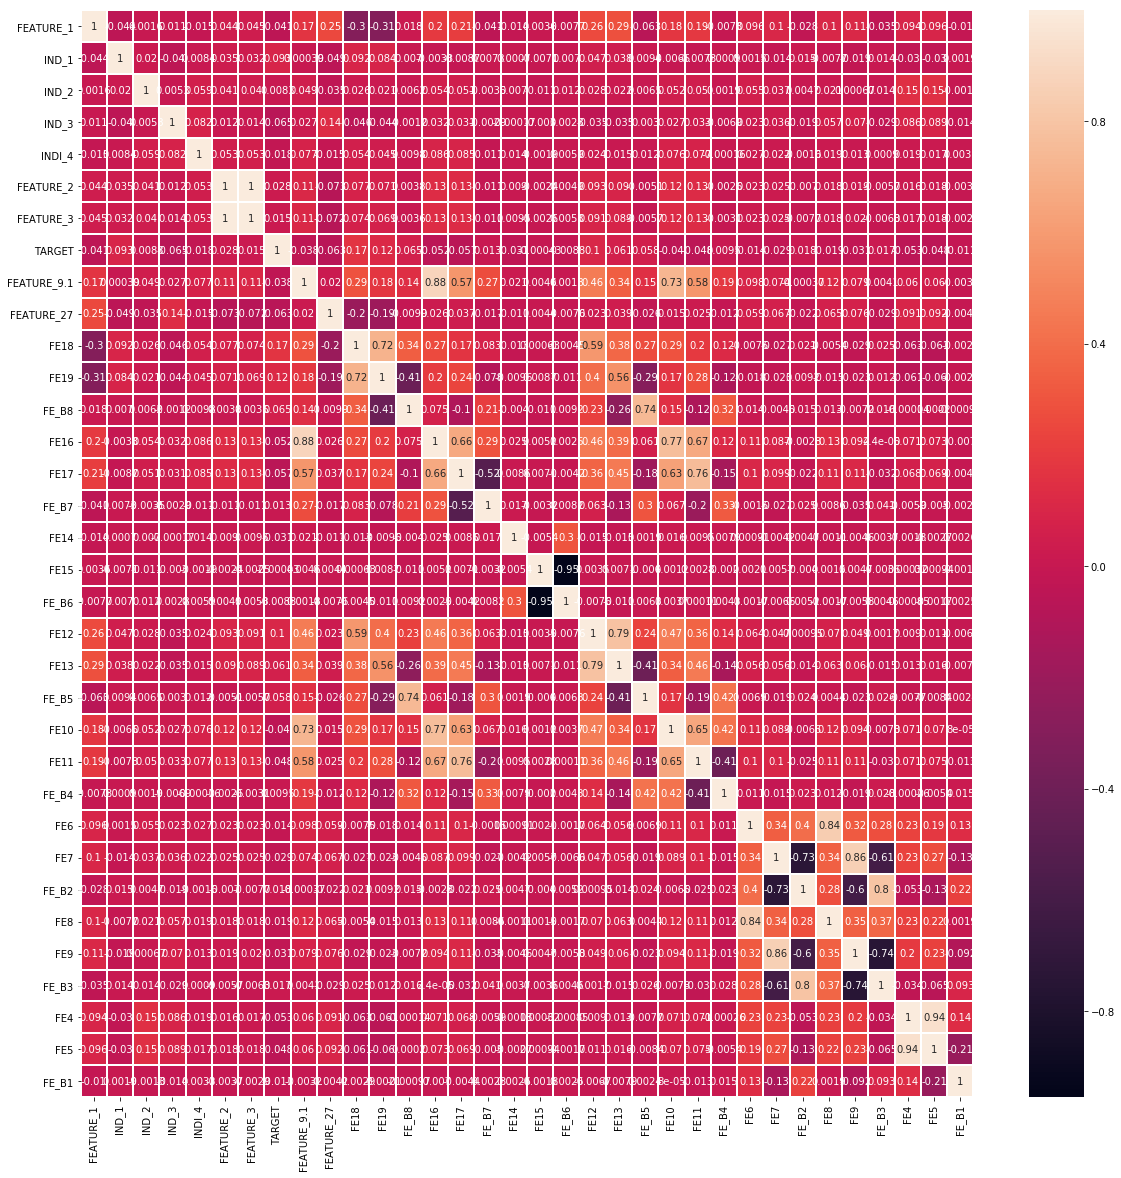

In [16]:
cor_matrix=Train_data.corr()
cor_matrix
plt.figure(figsize = (20,20))
sns.heatmap(cor_matrix, annot=True,linewidths=1)

NEURAL NETWORK MODEL 

In [ ]:
#NON SIGNIFICANT COLUMNS
'FE_B6','FE5','ETHNIC' , 'MARITAL_STATUS'

In [ ]:
def create_model(optimizer='adam', init='uniform'):
    # create model
    #if verbose: print("**Create model with optimizer: %s; init: %s" % (optimizer, init) )
    model = Sequential()
    from keras import regularizers
    from keras.callbacks import EarlyStopping
    EarlyStopping(monitor='val_err',patience=10)
    model.add(Dense(50, input_dim=n_cols,kernel_regularizer=regularizers.l2(0.1),activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(20, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
run_gridsearch = False

if run_gridsearch:

    epochs=[10,20,30]
    batch_size = [10, 20, 40]
    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
    momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]#hoow much should learn from previos epoch
    ##init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    #activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    weight_constraint = [1, 2, 3, 4, 5]#max 5
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    #neurons = [1, 5, 10, 15, 20, 25, 30]# model.add(Dense(neurons, input_dim=71, kernel_initializer='normal', activation='relu'))

    model = KerasClassifier(build_fn=create_model, verbose=verbose)
    
    param_grid = dict(epochs=epochs,batch_size = batch_size,optimizer=optimizer,learn_rate = learn_rate,
                  momentum = momentum,'''init_mode =init_mode ,activation =activation''',dropout_rate=dropout_rate, 
                  weight_constraint=weight_constraint''',neurons =neurons''' )

    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(x_train,y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #best params
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']
    best_init = grid_result.best_params_['init']
    best_optimizer = grid_result.best_params_['optimizer']
    
else:
    # pre-selected paramters
    best_epochs = 500
    best_batch_size = 32
    best_init = 'glorot_uniform'
    best_optimizer = 'rmsprop'
model_pred = KerasClassifier(build_fn=create_model, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=1)
model_pred.fit(x_train_res,y_train_res, validation_data = (x_test, y_test))

In [17]:
Train_data
Model_inp=Train_data.drop(['TARGET','FE_B6','FE5','ETHNIC' , 'MARITAL_STATUS'],axis=1)
x=pd.get_dummies(Model_inp)
print(Model_inp.shape)
#print(model_inp.columns.tolist())
y=Train_data['TARGET']
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.3,random_state=0)

#normalizing the data
sc=StandardScaler()
X_train=sc.fit_transform(x_train)
X_test=sc.transform(x_test)
#from imblearn.combine import SMOTEENN
# upsampling fro imbalanced dataset.
x_train_res,y_train_res=SMOTE().fit_sample(X_train, y_train)
n_cols=x_train_res.shape[1]
print("No of input features= ",n_cols)
#def create_model(optimizer='adam', init='uniform'):
Classifier=Sequential()
Classifier.add(Dense( units=35,activation="relu", kernel_initializer="uniform",input_dim=n_cols,)) 
Classifier.add(Dropout(rate=0.2))

Classifier.add(Dense(activation="relu", units=20, kernel_initializer="uniform")) 
Classifier.add(Dropout(rate=0.3))
Classifier.add(Dense(activation="relu", units=10, kernel_initializer="uniform")) 
Classifier.add(Dropout(rate=0.3))
#EarlyStopping(monitor='val_err',patience=10)
Classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))
Classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#return Classifier
Classifier.fit(x_train_res, y_train_res, batch_size = 32,epochs =10,validation_data = (X_test, y_test) )#,

(103252, 39)
No of input features=  85
Train on 133476 samples, validate on 30976 samples
Epoch 1/10
133476/133476 [==============================] - 7s 52us/step - loss: 0.5489 - acc: 0.7324 - val_loss: 0.4827 - val_acc: 0.7669
Epoch 2/10
133476/133476 [==============================] - 6s 44us/step - loss: 0.4587 - acc: 0.7883 - val_loss: 0.3586 - val_acc: 0.8778
Epoch 3/10
133476/133476 [==============================] - 5s 39us/step - loss: 0.3801 - acc: 0.8272 - val_loss: 0.3103 - val_acc: 0.8926
Epoch 4/10
133476/133476 [==============================] - 6s 44us/step - loss: 0.3538 - acc: 0.8381 - val_loss: 0.3037 - val_acc: 0.8942
Epoch 5/10
133476/133476 [==============================] - 5s 39us/step - loss: 0.3422 - acc: 0.8444 - val_loss: 0.2836 - val_acc: 0.9062
Epoch 6/10
133476/133476 [==============================] - 5s 41us/step - loss: 0.3333 - acc: 0.8500 - val_loss: 0.3256 - val_acc: 0.8710
Epoch 7/10
133476/133476 [==============================] - 5s 41us/step - l

Predicting Test Data

In [18]:
y_mod=Classifier.predict(X_test)
y_pred1=(((y_mod[:,0])>0.50)*1).ravel()
y_pred_nn=np.concatenate((1-y_mod,y_mod), axis = 1)

print('NEURAL_NETS TEST ACCURACY =',(metrics.accuracy_score (y_test, y_pred1))*100)
cm=confusion_matrix(y_test,y_pred1)
test_matric=pd.DataFrame(cm,columns=['PRED-VE','PRED+VE'],index=['ACT-VE','ACT+VE'])
print(test_matric)
#######################
y_modt=Classifier.predict(X_train)
y_pred2=(((y_modt[:,0])>0.50)*1).ravel()
print('\n NEURAL_NETS TRAINING ACCURACY =',(metrics.accuracy_score (y_train, y_pred2))*100)
cm=confusion_matrix(y_train,y_pred2)
matric=pd.DataFrame(cm,columns=['PRED-VE','PRED+VE'],index=['ACT-VE','ACT+VE'])
matric

NEURAL_NETS TEST ACCURACY = 92.55875516528926
        PRED-VE  PRED+VE
ACT-VE    27080     1546
ACT+VE      759     1591

 NEURAL_NETS TRAINING ACCURACY = 93.36432564059992


,PRED-VE,PRED+VE
ACT-VE,63442,3296
ACT+VE,1500,4038


# MODEL EVALUATION

C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


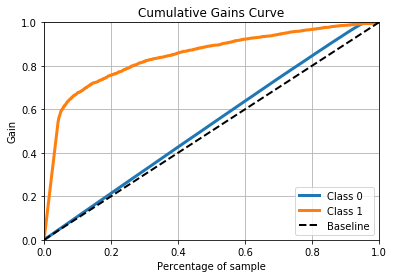

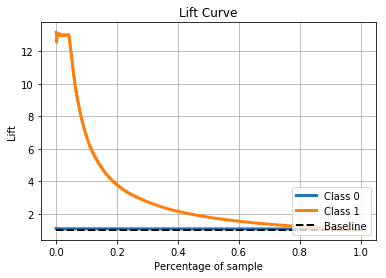

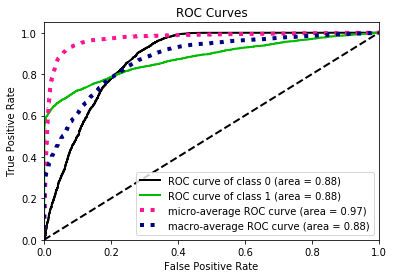

In [19]:
skplt.metrics.plot_cumulative_gain(y_test,y_pred_nn)
skplt.metrics.plot_lift_curve(y_test,y_pred_nn)
skplt.metrics.plot_roc (y_test,y_pred_nn)

RFE FEATURE SELECTION

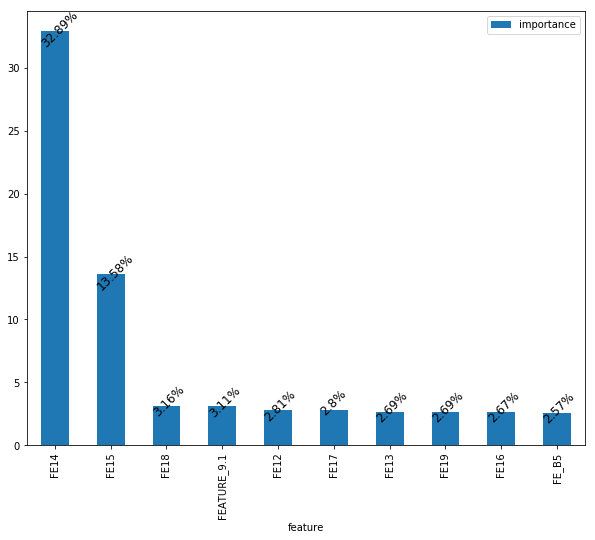

In [20]:
#Feature selection
from sklearn.ensemble import RandomForestClassifier

names = Train_data.columns
rf = RandomForestClassifier().fit(x_train,y_train)
rf.fit(x_train,y_train)
#print ("Features sorted by their score:")
#print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),names),reverse=True))
importances = pd.DataFrame({'feature':x.columns,'importance':np.round(rf.feature_importances_,4)*100})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
ax=importances.iloc[:10,:].plot.bar(figsize=(10,8))
#plt.figure(figsize=(30,25))
#importances
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03,i.get_height()+1,\
            str(round((i.get_height()/100)*100, 2))+'%', fontsize=12,color='black',rotation=45)#total)*100

# ERROR ANALYSIS

In [21]:
y_test_prob=Classifier.predict(X_test)             # X-test
prob_test=(((y_test_prob[:,0])>0.5)*1).ravel()
y_train_prob=Classifier.predict(X_train)          #x-train
prob_train=(((y_train_prob[:,0])>0.5)*1).ravel()
predicted_value=pd.concat( [pd.Series(prob_train),pd.Series(prob_test),],axis=0).reset_index().rename(
    columns={0:'PREDICTED_VALUE','index':"TRAIN_TEST_INDEX"})
actual_value=pd.concat([y_train,y_test],axis=0)     # y_train,y_test
Merging=pd.concat([predicted_value,pd.Series(np.array(actual_value)),pd.Series(np.array(actual_value.index))],axis=1).rename(columns={0:'ACTUAL_VALUE',1:'PARTY_ID'})
ERROR_DATA=Merging[['PARTY_ID','ACTUAL_VALUE','PREDICTED_VALUE']]  #ERROR DATA WITH ACTUAL AND PREDICTED VALUES
Responders_correctly_identified=ERROR_DATA[(ERROR_DATA['ACTUAL_VALUE']==1)&( ERROR_DATA['PREDICTED_VALUE']==1)]
print('Responders_correctly_identified=' ,Responders_correctly_identified.shape)
Non_Responders_correctly_identified=ERROR_DATA[(ERROR_DATA['ACTUAL_VALUE']==0)&( ERROR_DATA['PREDICTED_VALUE']==0)]
print('Non_Responders_correctly_identified=',Non_Responders_correctly_identified.shape)
Type1_error=ERROR_DATA[(ERROR_DATA['ACTUAL_VALUE']==0)&( ERROR_DATA['PREDICTED_VALUE']==1)]
print('Type1_error=', Type1_error.shape)
Type2_error=ERROR_DATA[(ERROR_DATA['ACTUAL_VALUE']==1)&( ERROR_DATA['PREDICTED_VALUE']==0)]
print('Type2_error=', Type2_error.shape)
ERROR_DATA.head()

Responders_correctly_identified= (5629, 3)
Non_Responders_correctly_identified= (90522, 3)
Type1_error= (4842, 3)
Type2_error= (2259, 3)


,PARTY_ID,ACTUAL_VALUE,PREDICTED_VALUE
0,B124622,0,0
1,B068102,0,0
2,B114579,0,1
3,B080519,0,0
4,B081996,0,0


In [22]:
print('size of train data=',Train_data.shape)
ind_var=Train_data.drop_duplicates()
print('size of ERROR_DATA=',ERROR_DATA.shape)
Responders=ind_var[ind_var.index.isin(Responders_correctly_identified['PARTY_ID'])]
print('Responders_data',Responders.shape)
Non_Responders=ind_var[ind_var.index.isin(Non_Responders_correctly_identified['PARTY_ID'])]
print('Non_Responders_data',Non_Responders.shape)
Type1_Error=ind_var[ind_var.index.isin(Type1_error['PARTY_ID'])]
print('Type1_Error_data=',Type1_Error.shape)
Type2_Error=ind_var[ind_var.index.isin(Type2_error['PARTY_ID'])]
print('Type2_Error_data=',Type2_Error.shape)

Type2_Error['ERROR']='FN'
Responders['ERROR']='TP'
E_DATA=pd.concat([Type2_Error,Responders],axis=0)
E_DATA.shape

size of train data= (103252, 44)
size of ERROR_DATA= (103252, 3)
Responders_data (5629, 44)
Non_Responders_data (90522, 44)
Type1_Error_data= (4842, 44)
Type2_Error_data= (2259, 44)


C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\tvimal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(7888, 45)

# Logistic-Regression 

In [ ]:

import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(1, 2, 10)
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(x_train_res,y_train_res)

#best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

# Predict target 
y_pred_tes = best_model.predict(X_test)
print(confusion_matrix(y_test,y_pred_tes ),'confusion_matrix')
print('testing_accuracy Log_REG =',(metrics.accuracy_score (y_test, y_pred_tes ))*100)
y_pred_train = best_model.predict(X_train)
print(confusion_matrix(y_train,y_pred_train),'confusion_matrix')
print('training_accuracy Log_REG =',(metrics.accuracy_score (y_train,y_pred_train))*100)

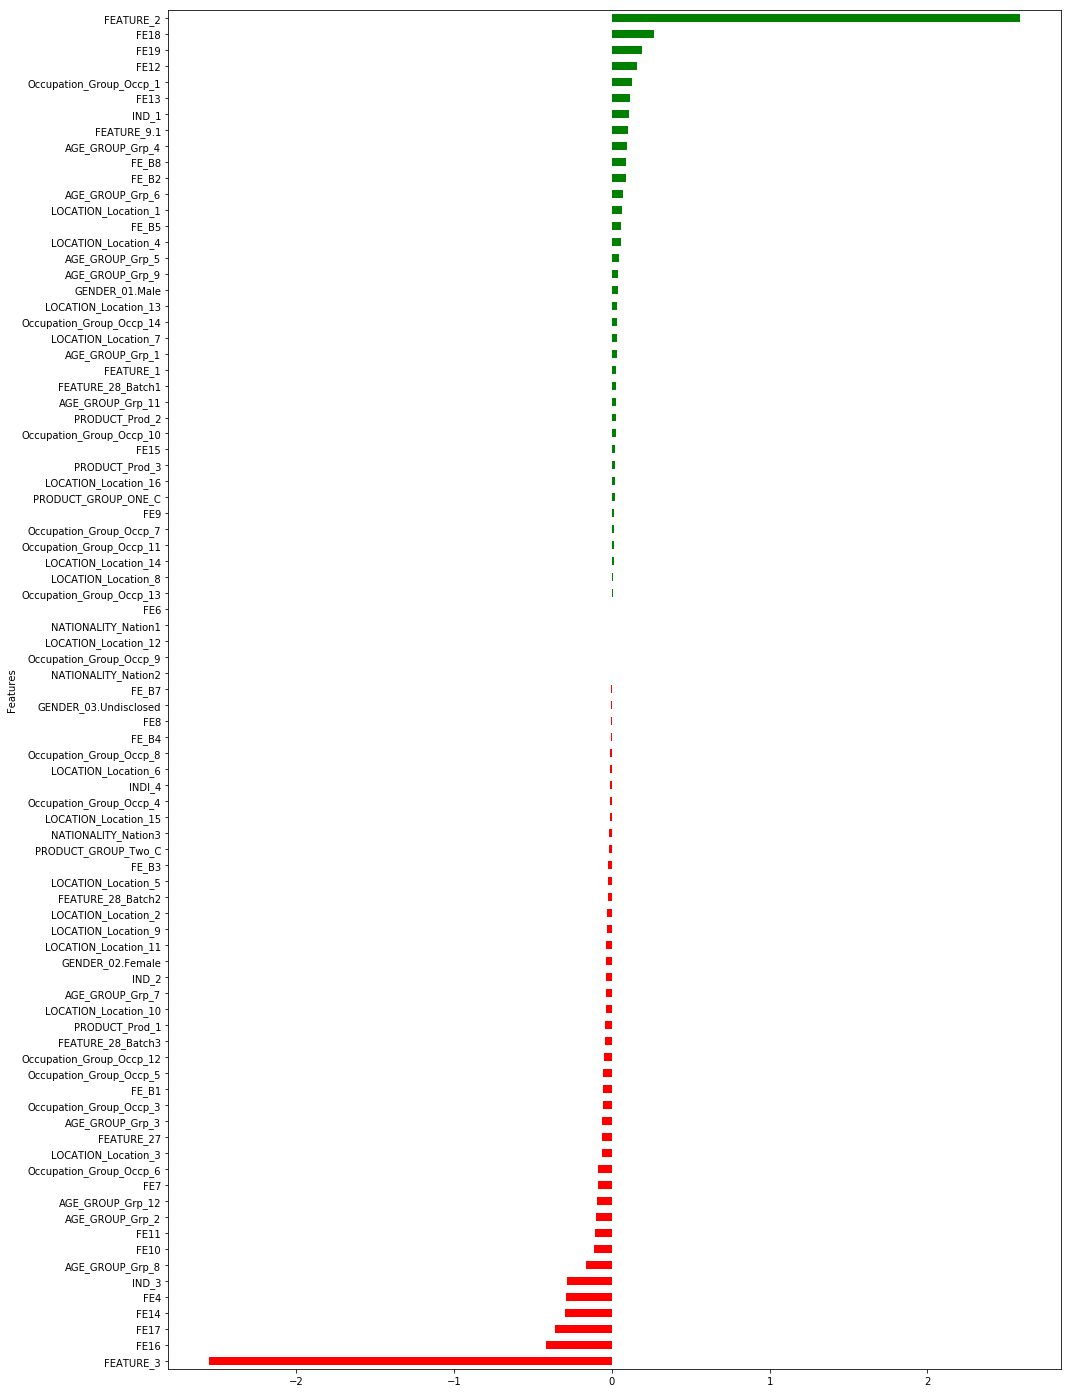

In [27]:
Log_reg=LogisticRegression(C=0.02)#
Log_reg.fit(x_train_res,y_train_res)
#feature impotance
coeff=Log_reg.coef_[0]
coef_df=pd.Series(coeff)
import matplotlib as plt
coeff = list(Log_reg.coef_[0])
labels = list(x.columns);features = pd.DataFrame()
features['Features'] = labels;features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(16, 25),color = features.positive.map({True: 'green', False: 'red'}))
#plt.xlabel('Importance')


In [23]:
# serialize model to JSON
model_json = Classifier.to_json()
with open("NN_WIEGHTS.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
Classifier.save_weights("NN_WIEGHTS.h5")
print("model Saved  to this working directory") 

model Saved  to this working directory


# SCORE NEW_DATA

In [29]:
from keras.models import model_from_json
# load json and create model
json_file = open('NN_WIEGHTS.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("NN_WIEGHTS.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
import teradata
import pandas as pd
host,user,pwd ='10.132.4.11','Dummy', "Dummy@123"
udaExec =teradata.UdaExec (appName="HelloWorld", version="1.0",logConsole=False)
with udaExec.connect(method="ODBC", system=host,username=user,password=pwd) as session:
    query = '''SELECT * from  dw_ckm.vim_cc_rev_final_leads01'''
    Score_Data= pd.read_sql(query,session)  

#imputation for outliers removal
sd1_cat=[];sd1_numl=[]    
for feature in Score_Data.columns.tolist():
    if Score_Data[feature].dtype=='object':
        sd1_cat.append(feature)
    else:
#sd1_cat=[feature  for feature in Score_Data.columns.tolist() if Score_Data[feature].dtype=='object' ]
#sd1_numl=[feature  for feature in Score_Data.columns.tolist() if Score_Data[feature].dtype!='object' ]
#imputation 
Score_Data[sd1_numl] = Imputer(strategy='mean').fit_transform(Score_Data[sd1_numl])
Score_Data= Score_Data.fillna(anal.mode().iloc[0])

score_data=pd.get_dummies(Score_Data)#S caps
# Get missing columns in the training test(x values should be in production template)
missing_cols = set( x.columns ) - set( score_data.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    score_data[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
score_data = score_data[x.columns]

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
score_data=sc.fit_transform(score_data)
print("backtest input shape",score_data.shape)

##########scoring new data
score2 = Classifier.predict_proba(score_data)
#score2 = Classifier.predict(score_data)
#prob=score[:,1]
out_prob=(score2>0.3).ravel()*1


CC_REV_LEADS=pd.DataFrame({'Party_ID':sd1.index,'Model_Probability':score2.ravel(),'Target':out_prob})
CC_REV_LEADS = CC_REV_LEADS.sort_values(by=['Model_Probability'], ascending=[False])
CC_REV_LEADS = CC_REV_LEADS.reset_index(drop=True)
CC_REV_LEADS.Target.value_counts()
#CC_REV_LEADS.to_excel('C:\\Users\\tvimal\\Desktop\\CC_MODELS\\CC_REVOLVER\\CC_REV_final_leads.xlsx')


import teradata
import pandas as pd
host,user,pwd ='10.132.4.11','Dummy', "Dummy@123"
udaExec =teradata.UdaExec (appName="HelloWorld", version="1.0",logConsole=False)
with udaExec.connect(method="ODBC", system=host,username=user,password=pwd) as session:
    query = '''create table dd_adhoc.vim_CC_REV_PL_analysis values(?,?,?)'''
    pl= pd.read_sql(query,CC_REV_LEADS,session)  
#print(df.columns.tolist()) #columns 
print(pl.shape) 